# Play with MOABB on the Thielen dataset

## Do the import

In [51]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from mne.decoding import Vectorizer
from pyriemann.estimation import Xdawn, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


import moabb

In [52]:
from moabb.datasets import Thielen2021
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import CVEP

moabb.set_log_level("info")
warnings.filterwarnings("ignore")

## Instantiating Dataset
 ---------------------

 The first thing to do is to instantiate the dataset that we want to analyze.
 MOABB has a list of many different datasets, each one containing all the
 necessary information for describing them, such as the number of subjects,
 size of trials, names of classes, etc.

 The dataset class has methods for:

 - downloading its files from some online source (e.g. Zenodo)
 - importing the data from the files in whatever extension they might be
   (like .mat, .gdf, etc.) and instantiate a Raw object from the MNE package

In [53]:
datasets = Thielen2021()
print(datasets.subject_list)
print(datasets.event_id)

#datasets.subject_list = [1, 2, 3]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'1.0': 101, '0.0': 100}


In [54]:
sessions = datasets.get_data(subjects=[1])

print(sessions)

subject = 1
session_name = "0"
run_name = "4"
raw = sessions[subject][session_name][run_name]

print(raw)


{1: {'0': {'0': <RawGDF | sub-01_20181128_block_1_main_eeg.gdf, 11 x 341479 (666.9 s), ~28.7 MB, data loaded>, '1': <RawGDF | sub-01_20181128_block_2_main_eeg.gdf, 11 x 341107 (666.2 s), ~28.6 MB, data loaded>, '2': <RawGDF | sub-01_20181128_block_3_main_eeg.gdf, 11 x 341105 (666.2 s), ~28.6 MB, data loaded>, '3': <RawGDF | sub-01_20181128_block_4_main_eeg.gdf, 11 x 341018 (666.0 s), ~28.6 MB, data loaded>, '4': <RawGDF | sub-01_20181128_block_5_main_eeg.gdf, 11 x 340901 (665.8 s), ~28.6 MB, data loaded>}}}
<RawGDF | sub-01_20181128_block_5_main_eeg.gdf, 11 x 340901 (665.8 s), ~28.6 MB, data loaded>


340901


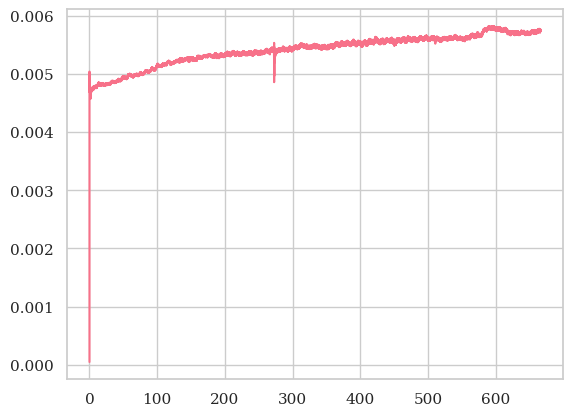

In [55]:
print(len(raw[1][0][0]))
eeg = raw[8][0][0]
plt.plot(np.linspace(0,len(eeg)*1/512,len(eeg)), eeg)
plt.show()

## Choosing a Paradigm

In [56]:
paradigm=CVEP()
print(paradigm==None)

2023-11-09 17:14:02,533 WARNING MainThread moabb.paradigms.cvep Choosing the first None classes from all possible events.


False


In [57]:
#X, labels, meta = paradigm.get_data(dataset=datasets, subjects=datasets.subject_list)
print(datasets.event_id)

{'1.0': 101, '0.0': 100}


In [58]:

pipelines = {}
pipelines["RG+LDA"]=make_pipeline(
    XdawnCovariances(
        nfilter=2, estimator="lwf", xdawn_estimator="scm"
    ),
    TangentSpace(),
    LDA(solver="lsqr", shrinkage="auto"),
)

pipelines["Xdw+LDA"] = make_pipeline(
    Xdawn(nfilter=2, estimator="scm"), Vectorizer(), LDA(solver="lsqr", shrinkage="auto")
)
pipelines["RG+SVC"]=make_pipeline(
    XdawnCovariances(
        nfilter=2, estimator="lwf", xdawn_estimator="scm"
    ),
    TangentSpace(),
    SVC(),
)


In [59]:
paradigm = CVEP(resample=128)
print("charging dataset")
print(datasets.event_id)
datasets.subject_list = datasets.subject_list[:2]
print(datasets.subject_list)
datasets = [datasets]
overwrite = True  # set to True if we want to overwrite cached results
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="examples", overwrite=overwrite
)

results = evaluation.process(pipelines)

2023-11-09 17:14:04,303 WARNING MainThread moabb.paradigms.cvep Choosing the first None classes from all possible events.
2023-11-09 17:14:04,352 INFO MainThread moabb.evaluations.base Processing dataset: Thielen2021


charging dataset
{'1.0': 101, '0.0': 100}
[1, 2]


Thielen2021-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.


2023-11-09 17:26:25,071 INFO MainThread moabb.evaluations.base RG+LDA | Thielen2021 | 1 | 0: Score 0.647


No hdf5_path provided, models will not be saved.


2023-11-09 17:26:39,819 INFO MainThread moabb.evaluations.base Xdw+LDA | Thielen2021 | 1 | 0: Score 0.684


No hdf5_path provided, models will not be saved.


# PLot Result

NameError: name 'results' is not defined

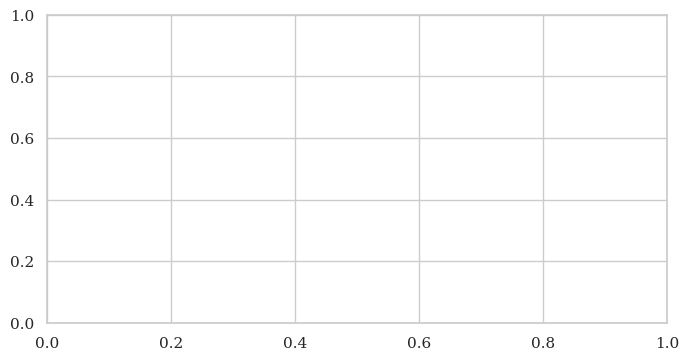

In [ ]:
fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=ax,
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=ax, palette="Set1")

ax.set_ylabel("ROC AUC")
ax.set_ylim(0.5, 1)

plt.show()